<a href="https://colab.research.google.com/github/tino926/new_ai_scripts/blob/main/huggingface_diffusers/huggingface_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ref: <https://machinelearningmastery.com/inpainting-and-outpainting-with-diffusers/>  
ref: <https://huggingface.co/docs/diffusers/using-diffusers/inpaint>  
ref: <https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers_doc/en/inpaint.ipynb#scrollTo=9Apdxcp_-kA3>  
ref: <https://medium.com/@nimritakoul01/image-inpainting-using-stable-diffusion-from-hugging-face-d68a26da9fd2>  

In [ ]:
import numpy as np
import torch
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
!pip install diffusers

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
from segment_anything import sam_model_registry, SamPredictor

!pip install diffusers accelerate
from diffusers import StableDiffusionInpaintPipeline

!wget -q -nc https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
CHECKPOINT_PATH='/content/sam_vit_b_01ec64.pth'

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2wivg5pp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2wivg5pp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=2e3c2f5e0aa1159aed1656e7b922717558d7f9d82ae9aae05f5eb89791e58014
  Stored in directory: /tmp/pip-ephem-wheel-cache-k4e7x7xx/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
print(DEVICE)

cuda:0


In [ ]:
!wget https://machinelearningmastery.com/wp-content/uploads/2024/04/inpaint-example.png

--2024-11-29 07:45:54--  https://machinelearningmastery.com/wp-content/uploads/2024/04/inpaint-example.png
Resolving machinelearningmastery.com (machinelearningmastery.com)... 172.67.72.46, 104.26.1.148, 104.26.0.148, ...
Connecting to machinelearningmastery.com (machinelearningmastery.com)|172.67.72.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107983 (105K) [image/png]
Saving to: ‘inpaint-example.png’

inpaint-example.png 100%[===================>] 105.45K  --.-KB/s    in 0.02s   

2024-11-29 07:45:54 (6.83 MB/s) - ‘inpaint-example.png’ saved [107983/107983]



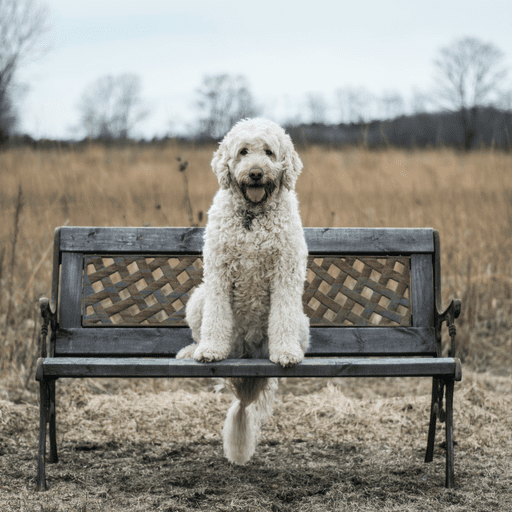

In [ ]:
# Give the path of your image
IMAGE_PATH = '/content/inpaint-example.png'
# Read the image from the path
image = cv2.imread(IMAGE_PATH)
cv2_imshow(image)
# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

In [ ]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

# Provide points as input prompt [X, Y]-coordinates
input_point = np.array([[250, 250]])
input_label = np.array([1])

# Predicting Segmentation mask
masks, scores, logits = mask_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


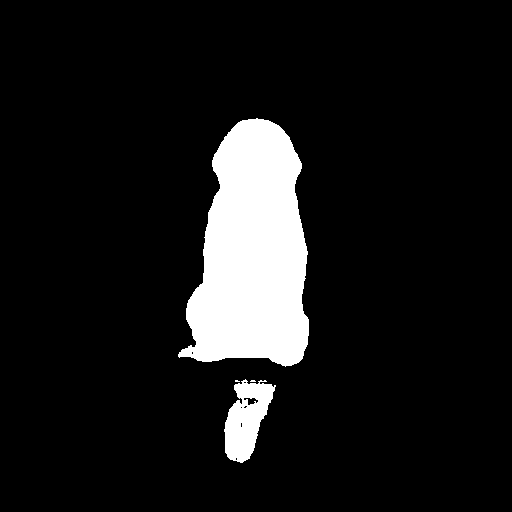

In [ ]:
mask = masks.astype(float) * 255
mask = np.transpose(mask, (1, 2, 0))
_ , bw_image = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
cv2_imshow(bw_image)
cv2.imwrite('mask.png', bw_image)
del sam, mask_predictor   # delete models to conserve GPU memory

In [ ]:
# !pip install --upgrade transformers diffusers

In [ ]:
# Load images using PIL
init_image = Image.open(IMAGE_PATH)
mask_image = Image.open('mask.png')

import requests
import PIL
from io import BytesIO
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))


pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

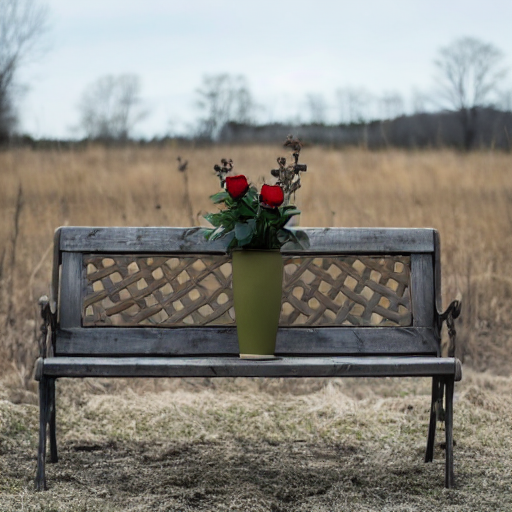

In [ ]:
prompt = "red roses in a tall vase"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
# convert image to opencv mat
image.save('output.png')

image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
cv2_imshow(image_cv)
